In [1]:
"""
Mount Google Colab Notebook correctly so we are in the correct relative directory
"""
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"3. COVID_Forecaster"

Mounted at /content/gdrive
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/3. COVID_Forecaster


In [2]:
"""
Ensure we have correct version of Pytorch Geometric before importing or installing anything else
"""
# Code in this cell is courtesy of: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7 
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch
import os

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal # added for GConvGRU
!pip install ogb

print("PyTorch has version {}".format(torch.__version__))

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 11.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 9.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 237 kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 11.8 MB/s 
     |████████████████████████████████| 370 kB 12.3 MB/s 
     |████████████████████████████████| 482 kB 38.4 MB/s 
     |████████████████████████████████| 41 kB 704 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=04f253f32a50eae8dd837f41e6e9ff93363165e04b116e180edd63a1de098f7c
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built

In [3]:
"""
Import any other libraries we will use later on
"""
! pip install epiweeks
! pip install haversine
from preprocess_data import get_preprocessed_data
from torch_geometric.data import Data

In [4]:
"""
Set device (CPU or GPU)
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
"""
Get preprocessed data
"""

import pickle

# # Get preprocessed data and unpackage variables needed during training/testing/validation
# preprocessed_data = get_preprocessed_data()
# # Save preprocessed data as pickle so we don't have to consecutively re-download the same data (time consuming) when re-running all cells in this notebook
# with open('./data/preprocessed_data.pickle', 'wb') as handle:
#     pickle.dump(preprocessed_data, handle)


# Load in saved preprocessed_data
preprocessed_data = None
with open('./data/preprocessed_data.pickle', 'rb') as handle:
    preprocessed_data = pickle.load(handle)





In [6]:
"""
Unpack preprocessed data
"""
training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

edge_index = preprocessed_data['edge_index']

train_x = training_variables['train_x_smoothed']
train_y = training_variables['train_y_change_in_confirmed_smoothed']

val_x = validation_variables['val_x_smoothed']
val_y = validation_variables['val_y_change_in_confirmed_smoothed']

test_x = testing_variables['test_x_smoothed']
test_y = testing_variables['test_y_change_in_confirmed_smoothed']

In [7]:
"""
Put preprocessed data into "Data" objects and put "Data" objects into tensors on the "device"
"""
training_data = []
validation_data = []
testing_data = []
for i in range(len(train_x)):
  toAppend = Data(x=train_x[i], y=train_y[i], edge_index=edge_index).to(device)
  training_data.append(toAppend)
for i in range(len(val_x)):
  toAppend = Data(x=val_x[i], y=val_y[i], edge_index=edge_index).to(device)
  validation_data.append(toAppend)
for i in range(len(test_x)):
  toAppend = Data(x=test_x[i], y=test_y[i], edge_index=edge_index).to(device)
  testing_data.append(toAppend)

In [8]:
"""
Define network architecture, optimizer, and loss function
"""
# Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html 
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric_temporal.nn.recurrent import GConvGRU

inputLayer_num_features = 24 
hiddenLayer1_num_features = 24
hiddenLayer2_num_features = 24
outputLayer_num_features = 15 # pred_window
chebyshev_filter_size = 2

class GCN(torch.nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = GCNConv(inputLayer_num_features, hiddenLayer1_num_features)
    #     self.conv2 = GCNConv(hiddenLayer1_num_features, outputLayer_num_features)

    def __init__(self):
      super().__init__()
      self.conv1 = GConvGRU(in_channels=inputLayer_num_features, out_channels=hiddenLayer1_num_features, K=chebyshev_filter_size)
      self.conv2 = GConvGRU(in_channels=hiddenLayer1_num_features, out_channels=hiddenLayer2_num_features, K=chebyshev_filter_size)
      self.linear1 = Linear(hiddenLayer2_num_features, outputLayer_num_features)

    # def forward(self, data):
    #     x, edge_index = data.x, data.edge_index
    #     x = self.conv1(x, edge_index)
    #     x = F.elu(x)
    #     x = self.conv2(x, edge_index)
    #     # print(x.shape)
    #     return x

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = self.linear1(x)
      return x

model = GCN().to(device)

"""Predicting confirmed cases with UNSMOOTHED DATA
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
# ==================================================================
# Saved best model
# Epoch 0, Loss 42769390666496.00, Val loss 1144893210624.00
# Epoch 1, Loss 43588523467264.00, Val loss 1144893210624.00
# Epoch 2, Loss 43588522479872.00, Val loss 1144893210624.00

# optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
# ==================================================================
# Saved best model
# Epoch 0, Loss 42782691710720.00, Val loss 1145398493184.00
# Epoch 1, Loss 43682803331840.00, Val loss 1145398493184.00
# Epoch 2, Loss 43682803230208.00, Val loss 1145398493184.00

# optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
# ==================================================================
# Saved best model
# Epoch 0, Loss 42842098256896.00, Val loss 1146748010496.00
# Epoch 1, Loss 44142974313472.00, Val loss 1146748010496.00
# Epoch 2, Loss 44142974349312.00, Val loss 1146748010496.00
# Epoch 3, Loss 44142974484992.00, Val loss 1146748010496.00
# Epoch 4, Loss 44142974195712.00, Val loss 1146748010496.00
# Epoch 5, Loss 44142974426624.00, Val loss 1146748010496.00
# Epoch 6, Loss 44142974675712.00, Val loss 1146748010496.00

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# ==================================================================
# Saved best model
# Epoch 30, Loss 45311937572864.00, Val loss 1152044630016.00

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# Saved best model
# Epoch 11, Loss 52422146342912.00, Val loss 1338975584256.00

# optimizer = torch.optim.Adam(model.parameters(), lr=10) 
# Saved best model
# Epoch 250, Loss 52617727680512.00, Val loss 1434736918528.00
# ==================================================================
"""

""" Predicting CHANGE IN CONFIRMED CASES with UNSMOOTHED DATA
# optimizer = torch.optim.SGD(model.parameters(), lr=5)
# ==================================================================
# Saved best model
# Epoch 10, Loss 1406912358.97, Val loss 44110352.00
# Epoch 11, Loss 1406912362.75, Val loss 44111736.00

## CURRENT ATTEMPT
# optimizer = torch.optim.SGD(model.parameters(), lr=3)
# ==================================================================
# Saved best model
# Epoch 1, Loss 9978198731645184.00, Val loss 4257833728.00
# Epoch 2, Loss 487194958592.00, Val loss 4257833728.00
# Epoch 3, Loss 487135717120.00, Val loss 4257833728.00
# Epoch 4, Loss 487123448320.00, Val loss 4257833728.00
# Epoch 5, Loss 487194958592.00, Val loss 4257833728.00
# Epoch 6, Loss 487194958592.00, Val loss 4257833728.00
# Epoch 7, Loss 487123672832.00, Val loss 4257833728.00

# optimizer = torch.optim.SGD(model.parameters(), lr=1)
# ==================================================================
# Saved best model
# Epoch 4, Loss 1254756897.00, Val loss 42590060.00
# Epoch 5, Loss 1254523141.75, Val loss 42590060.00
# Epoch 6, Loss 1254756964.66, Val loss 42590064.00
# Epoch 7, Loss 1254756966.41, Val loss 42590060.00
# Epoch 8, Loss 1254756963.06, Val loss 42590060.00

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# ==================================================================
# Saved best model
# Epoch 249, Loss 1230884550.44, Val loss 39618176.00
# ==================================================================
# Saved best model
# Epoch 250, Loss 1229793268.94, Val loss 39596024.00

# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# ==================================================================
# Saved best model
# Epoch 49, Loss 1303417711.12, Val loss 40663960.00
# Epoch 50, Loss 1307867300.75, Val loss 40700624.00
# Epoch 51, Loss 1307159946.75, Val loss 40732316.00
# Epoch 52, Loss 1306538857.00, Val loss 40759704.00

# optimizer = torch.optim.Adam(model.parameters(), lr=1)
# ==================================================================
# Saved best model
# Epoch 12, Loss 1340716037.00, Val loss 41348480.00
# Epoch 13, Loss 1338890136.38, Val loss 41497644.00
# Epoch 14, Loss 1339746923.50, Val loss 41397148.00
# Epoch 15, Loss 1340006091.38, Val loss 41366280.00

# optimizer = torch.optim.Adam(model.parameters(), lr=10)
# ==================================================================
# Saved best model
# Epoch 48, Loss 1410565205.31, Val loss 40933468.00
# Epoch 49, Loss 1410565144.25, Val loss 40933468.00
"""

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# ==================================================================
# Saved best model
# Epoch 2, Loss 844733180.70, Val loss 24130472.00
# Epoch 3, Loss 844733345.05, Val loss 24130472.00
# Epoch 4, Loss 844733344.17, Val loss 24130472.00


# optimizer = torch.optim.Adam(model.parameters(), lr=10)
# ==================================================================
# Saved best model
# Epoch 0, Loss 981986268.34, Val loss 23840134.00
# Epoch 1, Loss 1002387839.06, Val loss 23864630.00
# Epoch 2, Loss 1001558686.19, Val loss 23866456.00
# Epoch 3, Loss 1001384564.81, Val loss 23867010.00
# Epoch 4, Loss 1001299320.44, Val loss 23867208.00
# Epoch 5, Loss 1001249199.88, Val loss 23867278.00

# optimizer = torch.optim.Adam(model.parameters(), lr=1)
# ==================================================================
# Saved best model
# Epoch 24, Loss 926364984.75, Val loss 24568306.00

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.MSELoss()

In [9]:
model

GCN(
  (conv1): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (conv2): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (linear1): Linear(in_features=24, out_features=15, bias=True)
)

In [10]:
"""
Training
"""
model_path = './saved_models/smoothed_adam'
min_loss = 1e20

def train():
  total_loss = 0.0
  for data in training_data:
    model.train()
    optimizer.zero_grad()
    predicted_output = model(data)
    labeled_output = data.y.to(device)
    loss = criterion(predicted_output, labeled_output)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  return total_loss

def validation():
  model.eval()
  totalLoss = 0.0
  for data_validation in validation_data:
    validation_prediction_output = model(data_validation)
    labeled_validation_output = data_validation.y.to(device)
    loss = criterion(validation_prediction_output, labeled_validation_output)
    totalLoss += loss.item()
  return totalLoss

for epoch in range(1000):
  training_loss = train()
  val_loss = validation()
  if val_loss < min_loss:
    min_loss = val_loss
    state = {
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, model_path)
    print("==================================================================")
    print("Saved best model")
  print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, training_loss, val_loss))

Saved best model
Epoch 0, Loss 1195170853.03, Val loss 32638086.00
Saved best model
Epoch 1, Loss 1187919111.84, Val loss 32508062.00
Saved best model
Epoch 2, Loss 1181167663.00, Val loss 32383016.00
Saved best model
Epoch 3, Loss 1174625430.47, Val loss 32260538.00
Saved best model
Epoch 4, Loss 1168242720.26, Val loss 32140118.00
Saved best model
Epoch 5, Loss 1162003064.32, Val loss 32021536.00
Saved best model
Epoch 6, Loss 1155897721.48, Val loss 31904678.00
Saved best model
Epoch 7, Loss 1149920889.20, Val loss 31789462.00
Saved best model
Epoch 8, Loss 1144068223.09, Val loss 31675834.00
Saved best model
Epoch 9, Loss 1138336116.30, Val loss 31563742.00
Saved best model
Epoch 10, Loss 1132721481.65, Val loss 31453154.00
Saved best model
Epoch 11, Loss 1127221532.32, Val loss 31344024.00
Saved best model
Epoch 12, Loss 1121833719.92, Val loss 31236330.00
Saved best model
Epoch 13, Loss 1116555737.85, Val loss 31130048.00
Saved best model
Epoch 14, Loss 1111390683.54, Val loss 31

18428902.0
tensor([1442.2783, 1444.0994, 1444.4552, 1454.6398, 1456.0919, 1451.7969,
        1452.5723, 1451.3713, 1461.3315, 1465.0835, 1460.5835, 1461.7496,
        1460.9199, 1473.3818, 1477.2175], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([3277.7500, 3369.6250, 3381.3750, 2813.0000, 2813.0000, 3235.6250,
        3702.7500, 2925.1250, 3069.6250, 2597.1250, 2117.6250, 2117.6250,
        2634.7500, 3445.1250, 3173.5000], device='cuda:0')


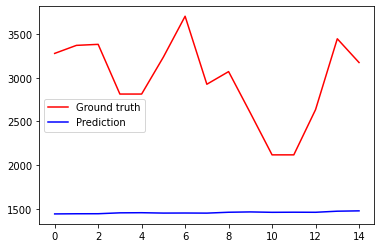

In [39]:
"""
Testing and plotting results
"""
import matplotlib.pyplot as plt

predicted_output = None
labeled_output = None
for data in validation_data:
  model.eval()
  predicted_output = model(data)
  labeled_output = data.y.to(device)
  loss = criterion(predicted_output, labeled_output)
  print(loss.item())

state_num = 23

print(predicted_output[state_num])
print(labeled_output[state_num])

plt.plot(labeled_output[state_num].cpu().detach().numpy(),c='r', label='Ground truth')
plt.plot(predicted_output[state_num].cpu().detach().numpy(),c='b', label='Prediction')
plt.legend()
plt.show()